# AI　Workshop 2021/11 第5章 分数次差分をとった特徴量
by tsuchida

> 各Functionはこちらのものを少しバグを治して、利用しています。
> https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/src/features/snippets.py

> **為替の日足クローズ値　USD／JPYのレートを使用します。**

### 目的:機械学習の学習で予測の精度をあげるために、重複したラベルの整理やラベルに対しての重み付けをすることで、金融データの不確実性を含めたラベルにして、機械学習を行うためのデータの変換方法を学ぶ


**[忘れないように：　そろそろライブラリを別にしないと！]**

### 前処理　以下のデータ取得して整形しています　　みずほ銀行　マーケットデータより

参照：https://www.mizuhobank.co.jp/market/quote.csv
 

ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from datetime import datetime

import requests
import io

データの取得と整形

In [2]:
# データダウンロード
url = 'https://www.mizuhobank.co.jp/market/quote.csv'
res = requests.get(url)
df_tmp = pd.read_csv(io.BytesIO(res.content), encoding='shift-jis', sep=",")

# データを整形
df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: 'Date'})
df_tmp = df_tmp.rename(columns={df_tmp.columns[1]: 'USD'})
df_tmp = df_tmp.drop(0, axis=0)
df_tmp = df_tmp.drop(1, axis=0)

close = pd.Series(df_tmp['USD'].tolist(), index=pd.to_datetime(df_tmp['Date']).tolist())
close = close[:].astype(float)
#print(close)

グラフ表示処理初期値の設定

In [3]:
# グラフ表示の初期値の設定
ymin = 99
ymax = 122
sxmin='2016-01-01'
sxmax=close.index.max().strftime('%Y-%m-%d')
xmin = datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.strptime(sxmax, '%Y-%m-%d')
figure_size = (22, 8)


## 1. 非定常データと定常データを確認する

時系列データをつかって、非定常データとはどんなものか、非定常データから定常データを取得するための方法を確認する。

非定常データの表示：終値のチャートそのものが非定常なデータ

　　　　　　　　　　価格の推移がわかる　これが「メモリー」として表現されている

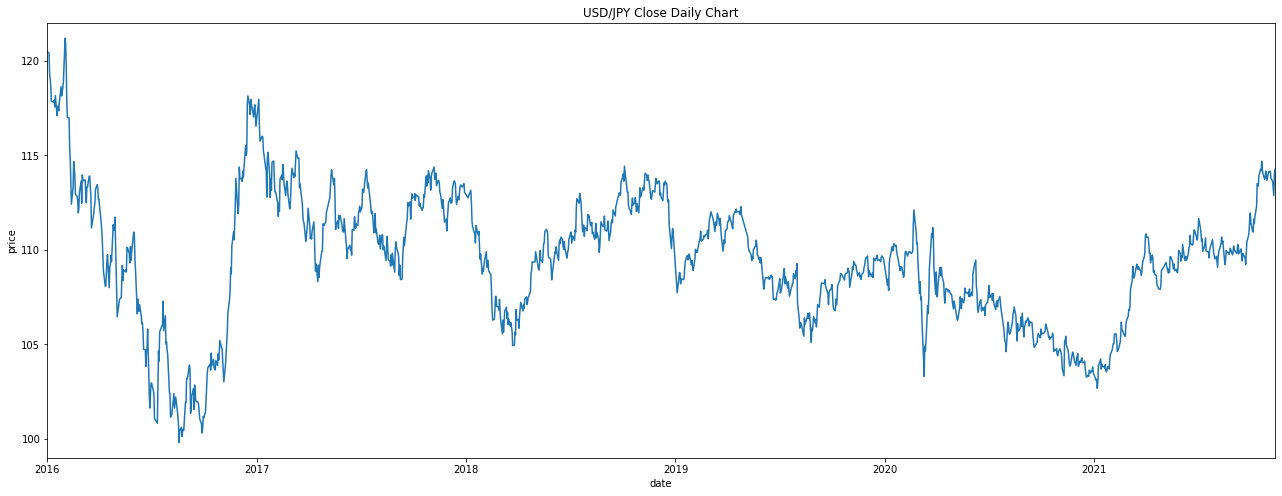

In [4]:
plt.rcParams["figure.figsize"] = figure_size
plt.plot(close.index, close[:])
plt.title("USD/JPY Close Daily Chart")
plt.xlabel('date')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('price')

plt.show()

定常データの表示：終値のチャートの１つ前のレートとの差分のみ取得したものが定常なデータ

　　　　　　　　　一つ前の価格との差分の変化がわかる

In [6]:
diff_close = close.diff(1)

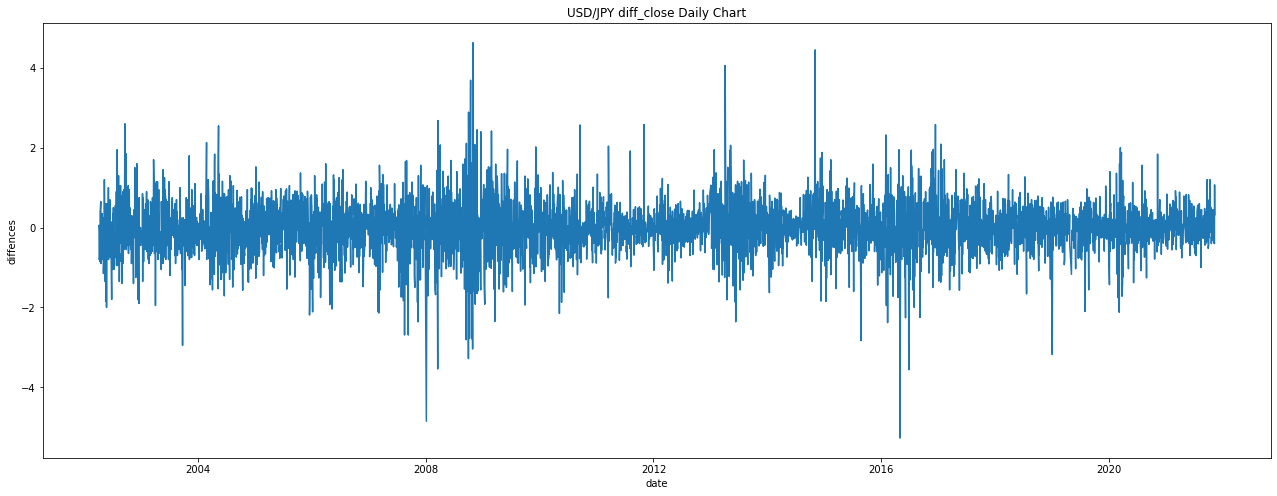

In [8]:
plt.rcParams["figure.figsize"] = figure_size
plt.plot(diff_close.index, diff_close[:])
plt.title("USD/JPY diff_close Daily Chart")
plt.xlabel('date')
plt.ylabel('diffences')

plt.show()

** 差分を取ると変化の差分しか残らないため、価格の推移が取り除かれてしまい、ここから特徴量を抽出しても価格の予測までは実現できない

##2. 分数次差分

分数次差分をとるために、データを増やすとウェイトの値が減衰していき、メモリーをデータから除外していく動きをするので、減衰していく様子を確認する。

次のグラフは横軸の値を増やしたとき、縦軸をウェイトの値がどのように変化するか、様々な 値で計算したものです。ウェイトは減衰傾向であることがグラフから読み取れます。

dの値は、d次差分の次差分のこと

####ウェイト取得　Function：getWeights

**前日と当日のレートの差をとり、売買いずれかの方向それぞれに差を蓄積し、
閾値を超えた場合にイベントとしてそのデータの日付を返す**




In [10]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w


#### ウェイト変化グラフ表示　Function：plotWeights

**指定した区間の日足の情報のボラティリティを計算して値を出力する**

**指数加重移動平均を使った標準偏差の値が出力される**



In [15]:
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot()
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()

### 2.1 ウェイト変化の確認

#### plotWeights[ 0, 1 ]


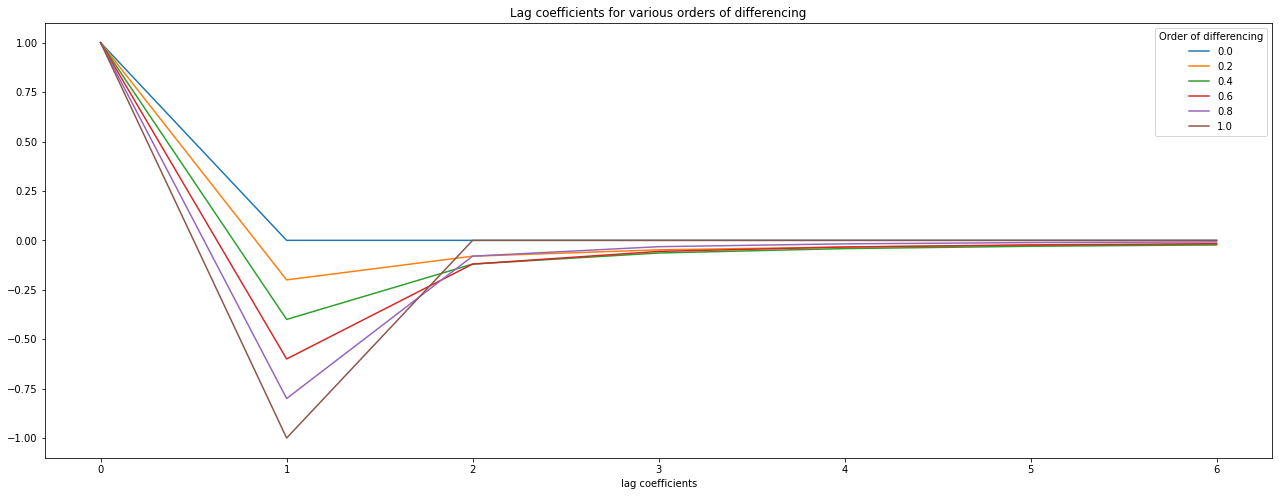

In [12]:
plotWeights([0,1],7,6)

#### plotWeights[ 1, 2 ]

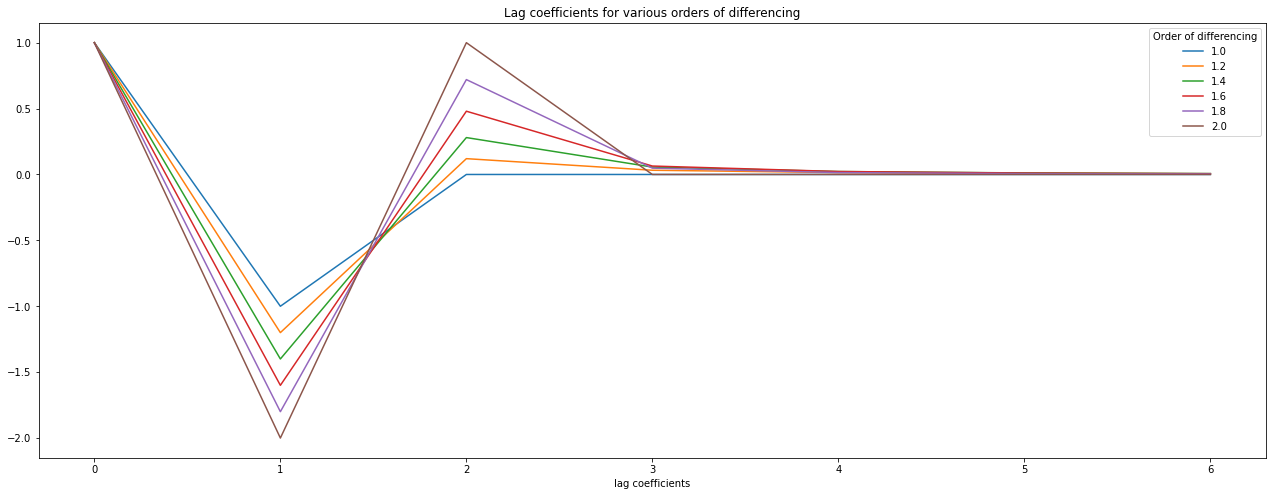

In [13]:
plotWeights([1,2],7,6)

## 3.拡大ウィンドウ　固定ウィンドウ

ファイナンス機械学習では、二種類の方法を紹介しています。

拡大ウィンドウ：ウェイトの長さが変化する
固定幅ウィンドウ：ウェイトの長さが変化しない


データの変換 Series => DataFrame

In [108]:
close_df = pd.DataFrame({'close': close})

### 3.1 拡大ウィンドウ

#### 拡大ウィンドウ　Function : fracDiff
*   series : 実はDataFrame
*   d：n次差分

In [99]:
def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily
        bounded between [0,1]
    '''
    #1) Compute weights for the longest series
    w=getWeights(d, series.shape[0])
    #bp()
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df, w

#### 拡大ウィンドウ　1次差分の場合の結果

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


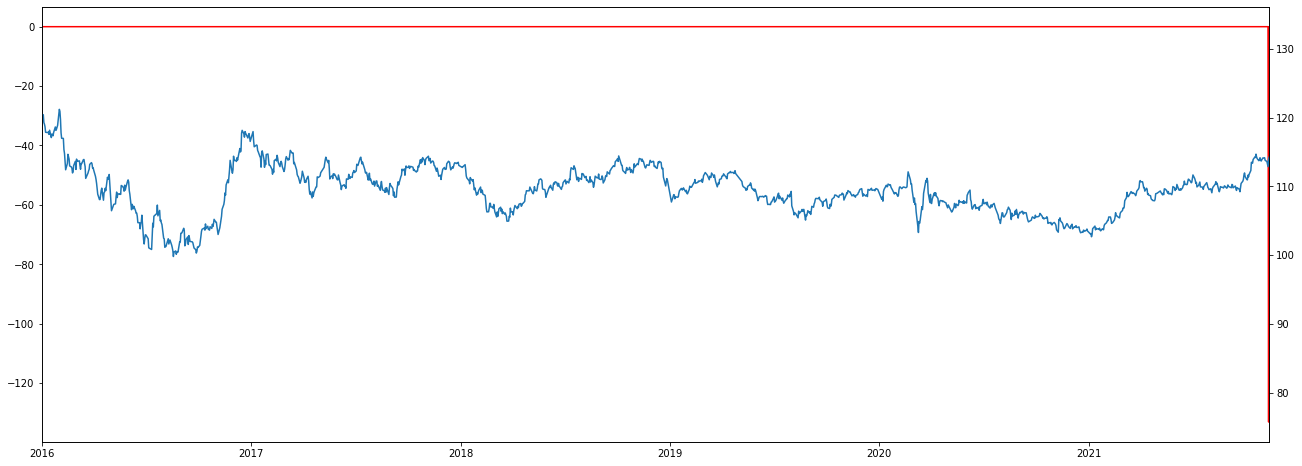

In [106]:
fdiff, w = fracDiff(close_df, d=1, thres=1)
y1 = fdiff['close']
y2 = close_df['close'].iloc[:]
x = close_df.index[:]

fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(x, y1, color="red")
ax2.plot(x, y2)
plt.xlim([xmin,xmax])
plt.show()

### 拡大ウィンドウ　0.25次差分の場合の結果

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


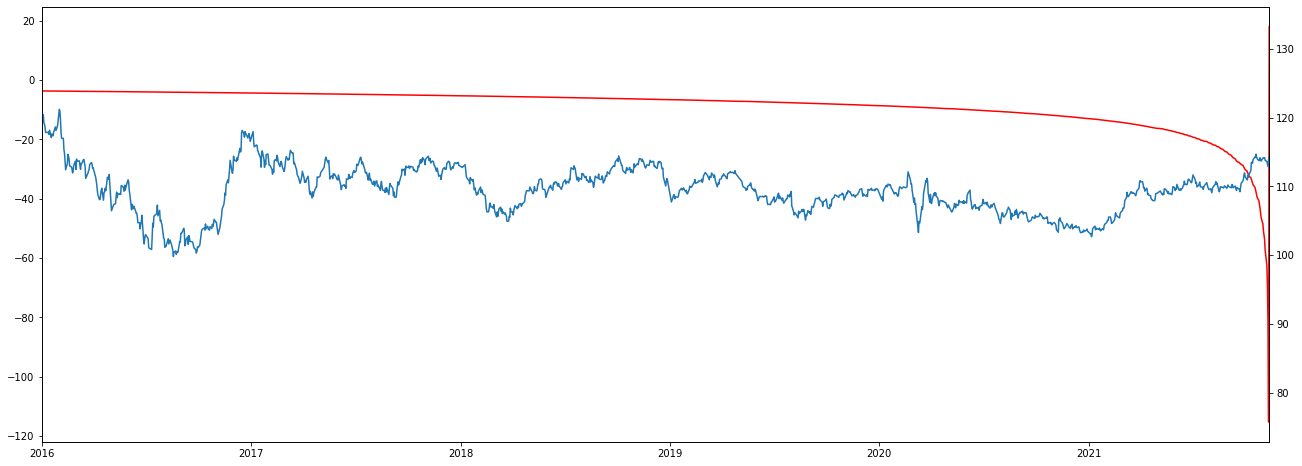

In [107]:
fdiff, w = fracDiff(close_df, d=0.25, thres=1)
y1 = fdiff['close']
y2 = close_df['close'].iloc[:]
x = close_df.index[:]

fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(x, y1, color="red")
ax2.plot(x, y2)
plt.xlim([xmin,xmax])
plt.show()

### 3.2 固定ウィンドウ

####固定ウィンドウのウェイト生成　Function：def getWeights_FFD

In [49]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)


####固定ウィンドウ　Function：fracDiff_FFD



In [40]:
def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w = getWeights_FFD(d,thres)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width], seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            #print(f'd: {d}, iloc1:{iloc1} shapes: w:{w.T.shape}, series: {seriesF.loc[loc0:loc1].notnull().shape}')
            try:
                df_.loc[loc1]=np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df ,w

###固定ウィンドウ　１次差分の場合の結果


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


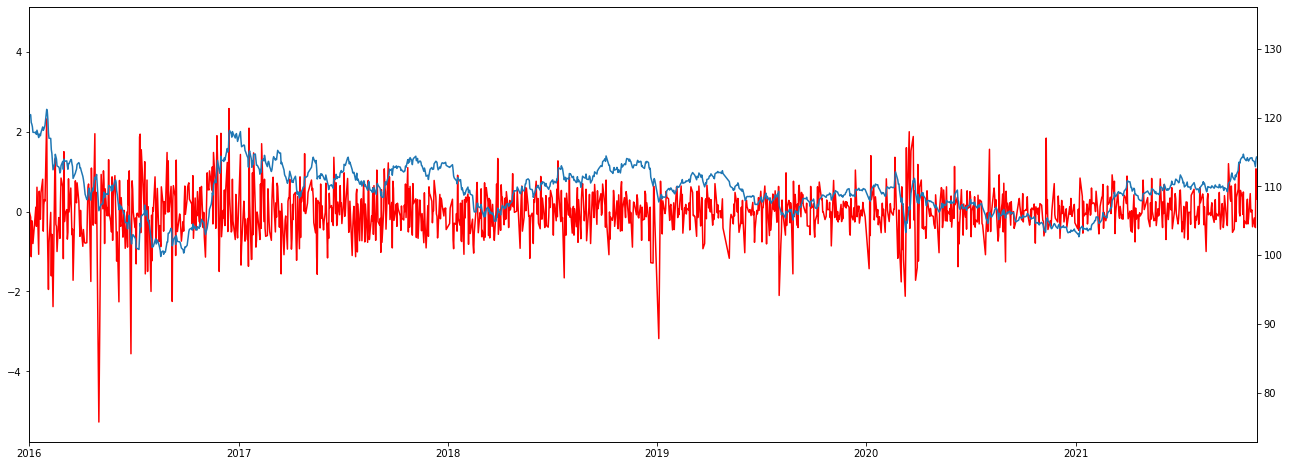

In [96]:
fdiff, w = fracDiff_FFD(close_df, d=1)

y1 = fdiff['close']
y2 = close_df['close'].iloc[(len(w) - 1):]
x = close_df.index[(len(w) - 1):]

fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(x, y1, color="red")
ax2.plot(x, y2)
plt.xlim([xmin,xmax])
plt.show()

### 固定ウィンドウ　0.25次差分の場合の結果

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


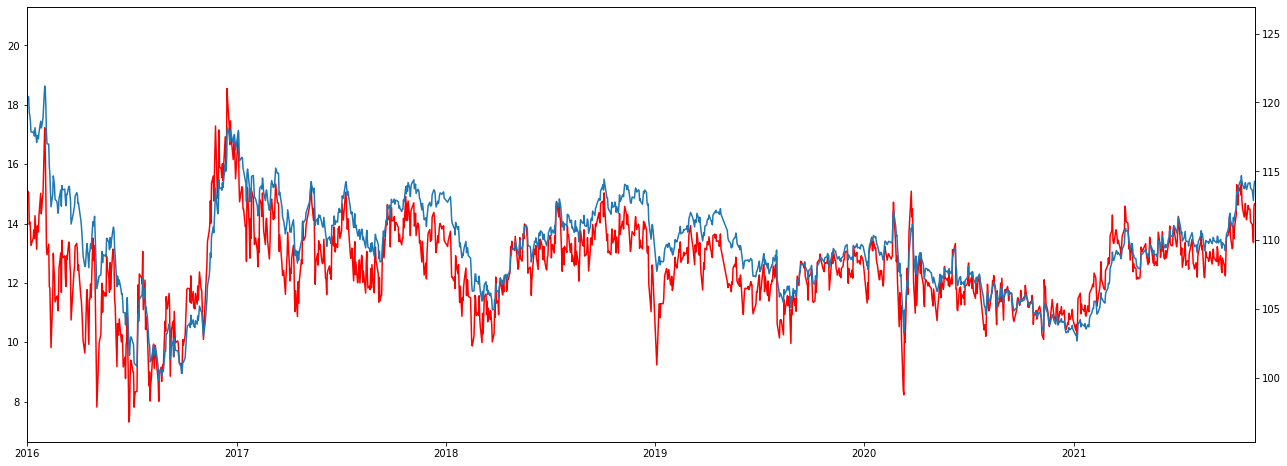

In [97]:
fdiff, w = fracDiff_FFD(close_df, d=0.25)

y1 = fdiff['close']
y2 = close_df['close'].iloc[(len(w) - 1):]
x = close_df.index[(len(w) - 1):]

fig = plt.figure()

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(x, y1, color="red")
ax2.plot(x, y2)
plt.xlim([xmin,xmax])
plt.show()